In [64]:
chrom = '22'
family_sizes = [5]
data_dir = '../split_gen_miss'

In [65]:
import numpy as np

# Pull chrom length from cytogenetic coordinates
chrom_length = 0
xticks, xticklabels = [], []
with open('../data/cytoBand.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
            chrom_length = max(chrom_length, int(pieces[1]), int(pieces[2]))
print('Chrom length', chrom_length)

Chrom length 51304566


In [66]:
from collections import Counter

phase_dir = '../phased'
# sample_ids
families = dict()
sample_ids = []
for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf:
        next(famf) # skip header
        for line in famf:
            pieces = line.strip().split('\t')
            families[pieces[0]] = pieces[1:(1+j)]
            sample_ids.extend(pieces[1:(1+j)])
            
family_to_index = dict([(x, i) for i, x in enumerate(families)])
sample_id_to_index = dict([(x, i) for i, x in enumerate(sample_ids)])
m = 4*len(family_to_index)
print('m', m)

m 12


In [67]:
from scipy import sparse
from os import listdir

clean_file = '%s/clean_indices_%s.txt' % (data_dir, chrom) 

# use only "cleaned" variants - must be SNPs and missingness in parents can't be sex-biased
snp_indices = []
snp_positions = []
with open(clean_file, 'r') as f:
    for i, line in enumerate(f):
        index, position = line.strip().split('\t')
        snp_indices.append(int(index))
        snp_positions.append(int(position))
snp_positions = np.array(snp_positions)
pos_to_index = dict([(x, i) for i, x in enumerate(snp_positions)])

n = len(pos_to_index)
print('n', n)

n 1004649


In [68]:
from collections import defaultdict

# load deletions
phase_dir = '../phased'
deletions1 = np.zeros((m, n), dtype=np.int8)-1
inheritance1 = np.zeros((2*len(sample_ids), n), dtype=np.int8)-1 

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
    open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
        next(famf) # skip header
        next(phasef) # skip header
        
        fam_pieces = (None,)
        
        for line in phasef:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            state = list(map(int, pieces[1:(1+(j*2))]))
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            
            # make sure we're on the right family
            while family_key != fam_pieces[0]:
                fam_pieces = next(famf).strip().split('\t')
                fam_individuals = fam_pieces[1:(1+j)]
                fam_indices = sum([[2*sample_id_to_index[x], (2*sample_id_to_index[x])+1] for x in fam_individuals[2:]], [])
                
            if family_key in family_to_index:
                deletions1[4*family_to_index[family_key], start_index:(end_index+1)] = state[0]
                deletions1[(4*family_to_index[family_key])+1, start_index:(end_index+1)] = state[1]
                deletions1[(4*family_to_index[family_key])+2, start_index:(end_index+1)] = state[2]
                deletions1[(4*family_to_index[family_key])+3, start_index:(end_index+1)] = state[3]
                
            inheritance1[fam_indices, start_index:(end_index+1)] = np.tile(state[4:], (end_index-start_index+1, 1)).T

In [69]:
from collections import defaultdict

# load deletions
phase_dir = '../phased50'
deletions2 = np.zeros((m, n), dtype=np.int8)-1

for j in family_sizes:
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as famf, \
    open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as phasef:
        next(famf) # skip header
        next(phasef) # skip header
        
        fam_pieces = (None,)
        
        for line in phasef:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            state = list(map(int, pieces[1:(1+(j*2))]))
            start_pos, end_pos = [int(x) for x in pieces[(1+(j*2)):(3+(j*2))]]
            start_index, end_index = pos_to_index[start_pos], pos_to_index[end_pos]
            
            # make sure we're on the right family
            while family_key != fam_pieces[0]:
                fam_pieces = next(famf).strip().split('\t')
                fam_individuals = fam_pieces[1:(1+j)]
                
            if family_key in family_to_index:
                deletions2[4*family_to_index[family_key], start_index:(end_index+1)] = state[0]
                deletions2[(4*family_to_index[family_key])+1, start_index:(end_index+1)] = state[1]
                deletions2[(4*family_to_index[family_key])+2, start_index:(end_index+1)] = state[2]
                deletions2[(4*family_to_index[family_key])+3, start_index:(end_index+1)] = state[3]

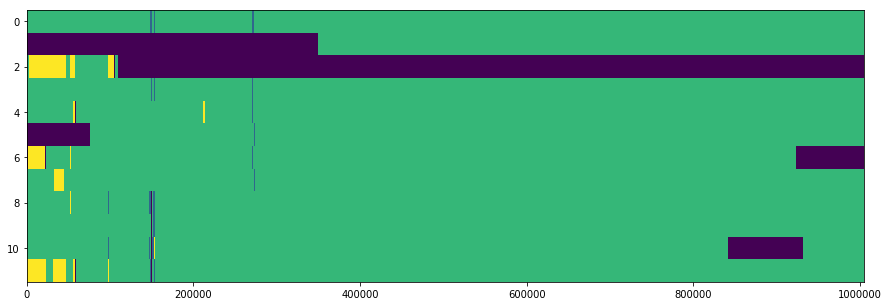

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.imshow(deletions1, aspect='auto', vmax=2, vmin=-1)
plt.show()

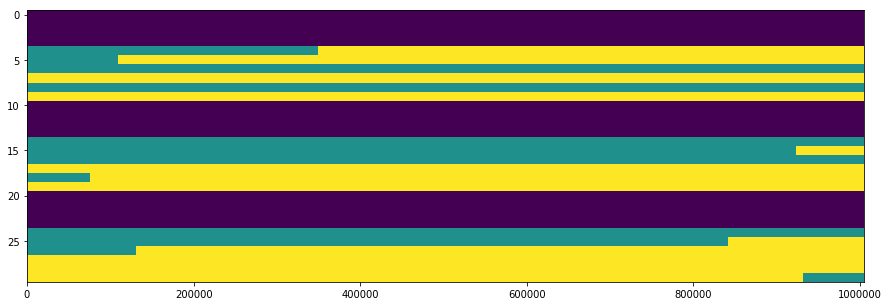

In [71]:
plt.figure(figsize=(15, 5))
plt.imshow(inheritance1, aspect='auto', vmax=1, vmin=-1)
plt.show()

In [72]:
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)

# pull families with sequence data
with open(sample_file, 'r') as f:
    gen_sample_ids = [line.strip() for line in f]
gen_sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(gen_sample_ids)])
gen_indices = [gen_sample_id_to_index[x] for x in sample_ids]

gen_files = sorted([f for f in listdir(data_dir) if ('chr.%s' % chrom) in f and 'gen.npz' in f])

# pull genotype data from .npz
whole_chrom = sparse.hstack([sparse.load_npz('%s/%s' % (data_dir, gen_file))[gen_indices, :] for gen_file in gen_files])
whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print('chrom shape only SNPs', m, n)

chrom shape only SNPs 15 1004649


In [107]:
# pull events
anc_index = 2
start_indices = np.where((deletions1[anc_index, :-1] == 1) & (deletions1[anc_index, 1:] != 1))[0]+1
end_indices = np.where((deletions1[anc_index, :-1] != 1) & (deletions1[anc_index, 1:] == 1))[0]


In [108]:
event_index = 0
start_index, end_index = start_indices[event_index]-10, end_indices[event_index]+10
print(start_index, end_index, snp_positions[start_index], snp_positions[end_index])
print(end_index-start_index, snp_positions[end_index]-snp_positions[start_index])

1853 47006 16099799 17039962
45153 940163


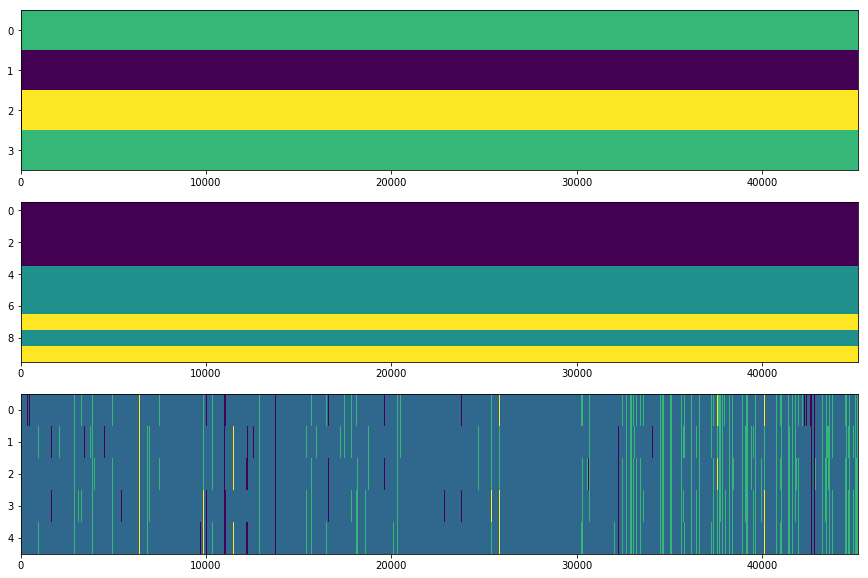

In [109]:
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.imshow(deletions1[:4, start_index:(end_index+1)], aspect='auto', vmax=2, vmin=-1)

plt.subplot(3, 1, 2)
plt.imshow(inheritance1[:10, start_index:(end_index+1)], aspect='auto', vmax=1, vmin=-1)

plt.subplot(3, 1, 3)
plt.imshow(whole_chrom[:5, start_index:(end_index+1)].A, aspect='auto', vmax=2, vmin=-1)

plt.show()